In [2]:
import patchseq_utils.analysis as utils
from patchseq_utils import dprime, pipelines as pipe, cluster_pairs as cp
import sklearn.model_selection as ms
from sklearn.naive_bayes import GaussianNB

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

pd.options.display.max_columns=300
pd.options.display.max_rows=300
sns.set(style='ticks', context='talk')

/local1/storage/envs/ipfx38/lib/python3.8/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
/local1/storage/envs/ipfx38/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from patchseq_utils import l1_load
from patchseq_utils import util
from importlib import reload
reload(l1_load)
reload(util)

<module 'patchseq_utils.util' from '/home/tom.chartrand/work/patchseq_human_L1/patchseq_utils/util.py'>

In [4]:
from patchseq_utils.l1_load import *
from patchseq_utils.util import *

In [5]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, LeaveOneOut
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler, PowerTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import plot_confusion_matrix

## NB confusion matrix comparison

CV accuracy: 0.61+/-0.07


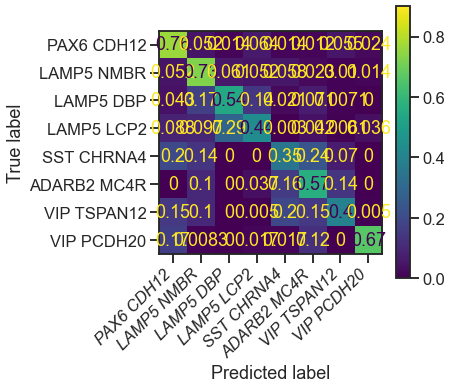

In [14]:
clf = GaussianNB()
# X0 = data[features].values
# X = pipe.preproc_pipeline().fit_transform(X0)
# types = data[cluster].astype('category')
# pipe.plot_cm(clf, X, types, include_values=False)
pipe.plot_cm(clf, data, features, cluster)

## ephys dprime

In [6]:
# ephys_data, clusters = subset_data(human_df, ephys_features, ephys_frac_min=0, cluster_min=10)
ephys_data, clusters = subset_data(human_df.loc[lambda df: (df.collaborator=="AIBS") &
                                            df.homology_type.notna()], 
                                ephys_features, ephys_frac_min=0, cluster_min=10)
complete_features = subset_features(ephys_data, ephys_features, complete_frac=0.8)
features = complete_features
# features = [x for x in complete_features if x != 'fast_trough_v_adapt_ratio']
data = ephys_data
data[cluster].cat.remove_unused_categories(inplace=True)
clusters = data[cluster].cat.categories
data[cluster].value_counts(dropna=False)

/tmp/ipykernel_12046/877023667.py:9: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  data[cluster].cat.remove_unused_categories(inplace=True)


LAMP5 NMBR     77
PAX6 CDH12     43
LAMP5 LCP2     33
ADARB2 MC4R    27
VIP TSPAN12    20
LAMP5 DBP      14
VIP PCDH20     12
SST CHRNA4     10
Name: t-type, dtype: int64

In [47]:
clf = GaussianNB()
ephys_dprime, records = cp.pairwise_cluster_distances(clf, data, features, cluster)
df = pd.DataFrame.from_records(records, index=['cluster_1', 'cluster_2'])
df['short_feat'] = df['feature'].map(short_feat)

In [48]:
pairwise_features = df.feature.unique()
pairwise_features

array(['tau', 'trough_deltav_hero', 'trough_slowdeltav_rheo',
       'upstroke_adapt_ratio', 'fast_trough_deltav_hero', 'sag',
       'sag_area', 'upstroke_downstroke_ratio_ramp', 'postap_slope_ramp',
       'fast_trough_v_adapt_ratio', 'upstroke_short_square', 'width_hero'],
      dtype=object)

In [49]:
df.short_feat.unique()

array(['tau', 'vAHP', 'vTrough', 'uAR', 'sag', 'sagA', 'u/d', 'ADP',
       'fAR', 'up', 'width'], dtype=object)

/local1/storage/envs/ipfx38/lib/python3.8/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


<AxesSubplot:>

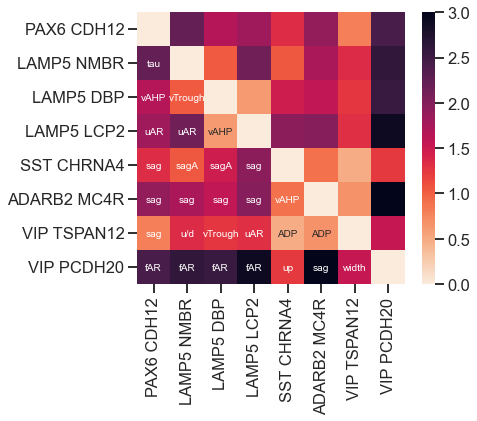

In [50]:
labels = (df.reset_index().pivot(index='cluster_1', columns='cluster_2', values='short_feat')
          .loc[clusters, clusters]
          .fillna(''))

fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(ephys_dprime, annot=labels, fmt='s', cmap='rocket_r',
            annot_kws=dict(size=10), vmin=0, vmax=3,
           cbar=True, ax=ax)

### dprime hierarchical clustering

In [107]:
plot_dprime_tree(clf, data, features, cluster, method='average')

/local1/storage/envs/ipfx3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/local1/storage/envs/ipfx3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less


ValueError: The condensed distance matrix must contain only finite values.

In [ ]:
plot_dprime_tree(clf, data, features, cluster, method='complete')

TypeError: '(array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3,
       4, 4, 4, 5, 5, 6]), array([1, 2, 3, 4, 5, 6, 7, 2, 3, 4, 5, 6, 7, 3, 4, 5, 6, 7, 4, 5, 6, 7,
       5, 6, 7, 6, 7, 7]))' is an invalid key

In [104]:
plot_dprime_tree(clf, data, features, cluster, method='weighted')

ValueError: The condensed distance matrix must contain only finite values.

### One vs All dprime

In [113]:
reload(cluster_pairs)

<module 'cluster_pairs' from '/allen/programs/celltypes/workgroups/humancelltypes/tom/projects/ephys_analysis/cluster_pairs.py'>

In [54]:
clf = GaussianNB()
dist, records = cp.ova_cluster_distances(clf, data, features, cluster, n_feat=4)
df = pd.DataFrame.from_records(records, index='cluster')

<AxesSubplot:>

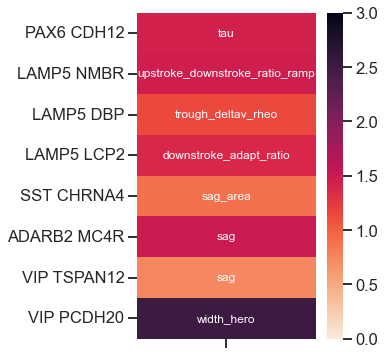

In [55]:
# overall dprime
fig, ax = plt.subplots(figsize=(4,6))
annot=df.loc[df['rank']==0, ['feature']]
sns.heatmap(dist[:,None], yticklabels=clusters, xticklabels=[''], annot=annot, fmt='s', cmap='rocket_r',
            annot_kws=dict(size=12), vmin=0, vmax=3,
           cbar=True, ax=ax)

<AxesSubplot:xlabel='rank'>

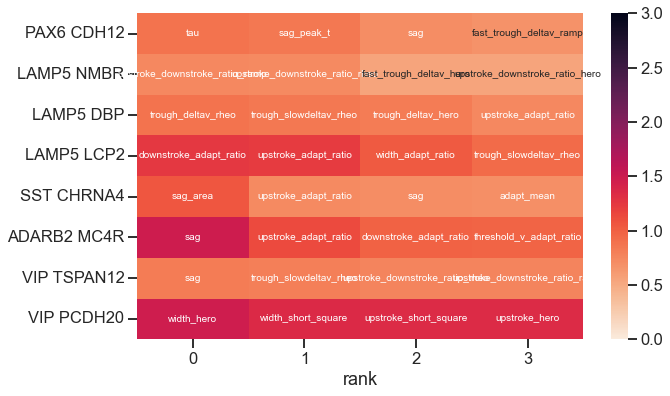

In [58]:
# Not cross-validated!
df2 = df.reset_index().pivot(index='cluster', columns='rank', values=['dprime','feature']).loc[clusters]

fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(df2['dprime'].astype('float'), cmap='rocket_r',  annot=df2['feature'], fmt='s', 
            annot_kws=dict(size=10),  cbar=True, ax=ax, vmin=0, vmax=3,)

In [35]:
reload(cluster_pairs)

<module 'cluster_pairs' from '/allen/programs/celltypes/workgroups/humancelltypes/tom/projects/ephys_analysis/cluster_pairs.py'>

In [36]:
# compare feature dprimes
# only showing top features, rest blanked out
dist, records = cluster_pairs.ova_cluster_distances(clf, data, features, cluster, n_feat=30)
df = pd.DataFrame.from_records(records, index='cluster')
df.reset_index().pivot(index='feature', columns='cluster', values=['dprime'])

dprime                                  \
cluster                        ADARB2 MC4R LAMP5 DBP LAMP5 LCP2 LAMP5 NMBR   
feature                                                                      
adapt_hero                        0.397631       NaN        NaN   0.296611   
adapt_max                              NaN       NaN   0.443643        NaN   
adapt_mean                             NaN       NaN   0.343236        NaN   
ahp_delay_ratio_5spike                 NaN       NaN   0.467275        NaN   
ahp_delay_ratio_hero                   NaN       NaN   0.811738        NaN   
...                                    ...       ...        ...        ...   
width_short_square                     NaN  0.452110        NaN        NaN   
width_suprathresh_hero                 NaN  0.481109   0.340392        NaN   
width_suprathresh_ramp                 NaN       NaN   0.473983        NaN   
width_suprathresh_rheo                 NaN  0.408845   0.513790        NaN   
width_suprathresh_short_square         NaN  0.487397        NaN        NaN   

                                                                             
cluster                        PAX6 CDH12 SST CHRNA4 VIP PCDH20 VIP TSPAN12  
feature                                                                      
adapt_hero                            NaN   0.391798   0.521715         NaN  
adapt_max                             NaN   0.676287   0.612640         NaN  
adapt_mean                            NaN   0.694448   0.775921         NaN  
ahp_delay_ratio_5spike           0.391439   0.385464   0.637688    0.473956  
ahp_delay_ratio_hero                  NaN        NaN   0.492574    0.679949  
...                                   ...        ...        ...         ...  
width_short_square                    NaN        NaN   1.357133    0.471156  
width_suprathresh_hero                NaN        NaN   1.300189    0.607790  
width_suprathresh_ramp                NaN        NaN   0.699334    0.454102  
width_suprathresh_rheo                NaN        NaN   0.955672    0.495557  
width_suprathresh_short_square        NaN        NaN   1.186781    0.437479  

[77 rows x 8 columns]

### metric / method variations

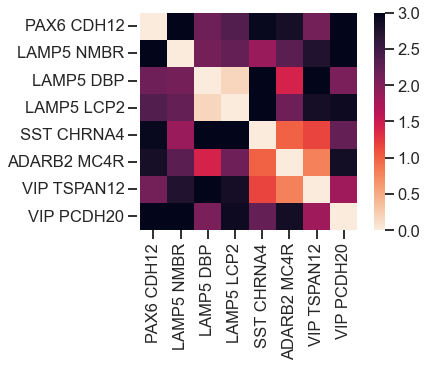

In [290]:
clf = LogisticRegression(class_weight='balanced')
ephys_dprime_log, records = cp.pairwise_cluster_distances(clf, ephys_data, complete_features, cluster, details=False)

plt.figure(figsize=(5,4))
df1 = cp.plot_dprime(clf, ephys_data, complete_features, cluster);

In [7]:
clf = RandomForestClassifier(class_weight='balanced')
ephys_dprime_rf, records = cp.pairwise_cluster_distances(clf, ephys_data, complete_features, cluster, details=False)
ephys_dprime_rf = ephys_dprime_rf.reindex(index=l1_types_human, columns=l1_types_human)

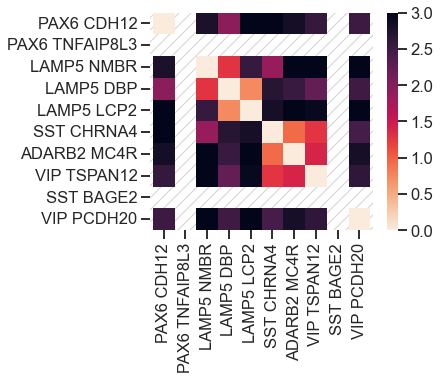

In [41]:
fig, ax = plt.subplots(figsize=(5,4))
# df1 = cp.plot_dprime(clf, ephys_data, complete_features, cluster);
# ax.add_patch(Rectangle((0, 0), 5, 5, fill=False, hatch='xx'))
g = sns.heatmap(ephys_dprime_rf, cmap='rocket_r', vmin=0, vmax=3, cbar=True, ax=ax, zorder=100)
# g.set_facecolor('xkcd:salmon')
ax.patch.set_edgecolor('lightgrey')
ax.patch.set_hatch('//')
plt.axis('equal')
plt.show()

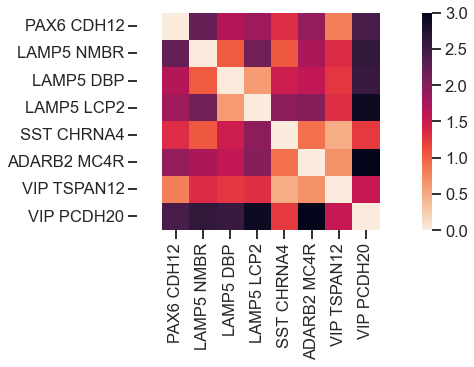

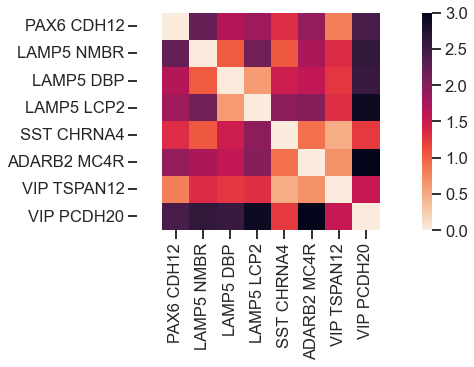

,PAX6 CDH12,LAMP5 NMBR,LAMP5 DBP,LAMP5 LCP2,SST CHRNA4,ADARB2 MC4R,VIP TSPAN12,VIP PCDH20
PAX6 CDH12,0.000000,0.000000,0.006061,0.000000e+00,0.0,0.0,0.0,0.000000e+00
LAMP5 NMBR,0.000000,0.000000,0.002147,0.000000e+00,0.0,0.0,0.0,0.000000e+00
LAMP5 DBP,0.006061,0.002147,0.000000,0.000000e+00,0.0,0.0,0.0,0.000000e+00
LAMP5 LCP2,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,-3.108624e-15
SST CHRNA4,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.000000e+00
ADARB2 MC4R,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.000000e+00
VIP TSPAN12,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.000000e+00
VIP PCDH20,0.000000,0.000000,0.000000,-3.108624e-15,0.0,0.0,0.0,0.000000e+00


In [78]:
clf = GaussianNB()
df1 = cp.plot_dprime(clf, ephys_data, complete_features, cluster);
df2 = cp.plot_dprime(clf, ephys_data, complete_features, cluster, method='predict_log_proba');
df1 - df2

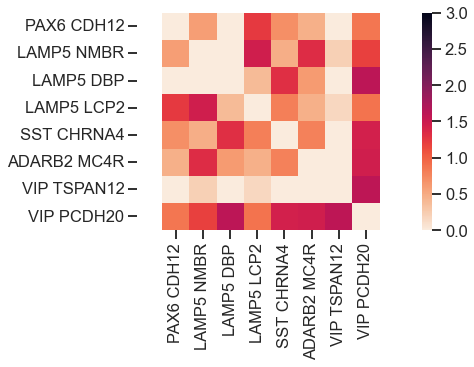

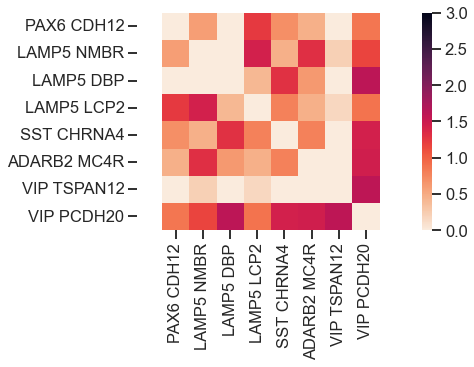

,PAX6 CDH12,LAMP5 NMBR,LAMP5 DBP,LAMP5 LCP2,SST CHRNA4,ADARB2 MC4R,VIP TSPAN12,VIP PCDH20
PAX6 CDH12,0.000000,-0.002737,0.000179,0.004052,0.001668,0.002090,0.002008,0.006792
LAMP5 NMBR,-0.002737,0.000000,0.000274,0.019510,0.004155,0.017005,0.008445,0.022387
LAMP5 DBP,0.000179,0.000274,0.000000,-0.013377,0.001815,-0.008513,-0.000724,0.000576
LAMP5 LCP2,0.004052,0.019510,-0.013377,0.000000,0.002199,0.002487,0.001050,0.001415
SST CHRNA4,0.001668,0.004155,0.001815,0.002199,0.000000,-0.001425,-0.000768,0.000259
ADARB2 MC4R,0.002090,0.017005,-0.008513,0.002487,-0.001425,0.000000,0.000333,0.006973
VIP TSPAN12,0.002008,0.008445,-0.000724,0.001050,-0.000768,0.000333,0.000000,0.006724
VIP PCDH20,0.006792,0.022387,0.000576,0.001415,0.000259,0.006973,0.006724,0.000000


In [79]:
clf = GaussianNB()
df1 = cp.plot_dprime(clf, ephys_data, complete_features, cluster, metric=cp.dprime_gaussian, method='predict_log_proba');
clf = GaussianNB(priors=(0.5, 0.5))
df2 = cp.plot_dprime(clf, ephys_data, complete_features, cluster, metric=cp.dprime_gaussian, method='predict_log_proba');
df1 - df2

## Subclass dprime

/local1/storage/envs/ipfx38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/local1/storage/envs/ipfx38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/local1/storage/envs/ipfx38/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:112: RuntimeWarning: invalid value encountered in less
  constant_mask = scale < 10 * np.finfo(scale.dtype).eps


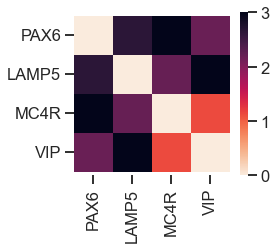

In [258]:
clf = GaussianNB()
clf = RandomForestClassifier(class_weight='balanced')
data = ephys_data.query('core_l1_type')
plt.figure(figsize=(3.5,3))
cp.plot_dprime(clf, data, ephys_features, cluster='homology_type');

/local1/storage/envs/ipfx3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/local1/storage/envs/ipfx3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1372: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/local1/storage/envs/ipfx3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:108: RuntimeWarning: invalid value encountered in less
  constant_mask = scale < 10 * np.finfo(scale.dtype).eps


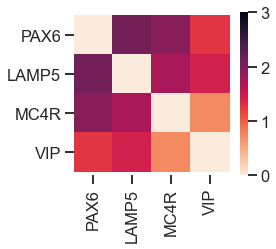

In [139]:
plt.figure(figsize=(3.5,3))
plot_dprime(clf, data, ephys_features, cluster='homology_type', cv=LeaveOneOut());

## Morpho dprime

In [269]:
clf = GaussianNB()
clf = RandomForestClassifier(class_weight='balanced')
data = human_df.query('core_l1_type')
features = morph_features
data, clusters = subset_data(data, features, ephys_frac_min=0, cluster_min=0)
data.homology_type.value_counts(dropna=False)

LAMP5    34
PAX6     21
MC4R     12
VIP       5
other     0
Name: homology_type, dtype: int64

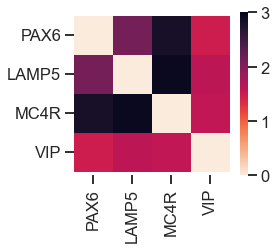

In [272]:
plt.figure(figsize=(3.5,3))
cp.plot_dprime(clf, data, morph_features, cluster='homology_type');

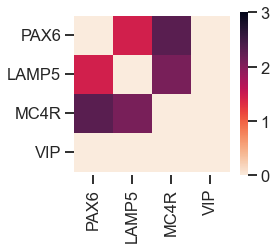

In [69]:
plt.figure(figsize=(3.5,3))
cp.plot_dprime(clf, data, morph_features, cluster='homology_type', cv=ms.LeaveOneOut());

### t-type level

In [276]:
data = human_df.query('l1_type')
ttype_data, clusters = subset_data(data, features, ephys_frac_min=0, cluster_min=5)

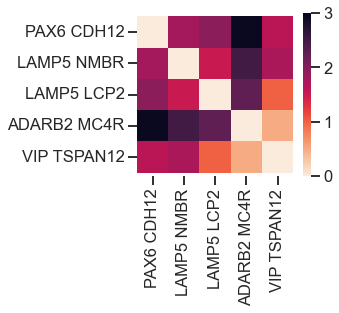

In [277]:
plt.figure(figsize=(3.5,3))
clf = RandomForestClassifier(class_weight='balanced')
cp.plot_dprime(clf, ttype_data, morph_features, cluster=cluster);

In [238]:

morph_dprime, records = cp.pairwise_cluster_distances(clf, ttype_data, features, cluster, details=False)

In [83]:

dist, records = cp.ova_cluster_distances(clf, data, features, cluster)
df = pd.DataFrame.from_records(records, index='cluster')

<AxesSubplot:>

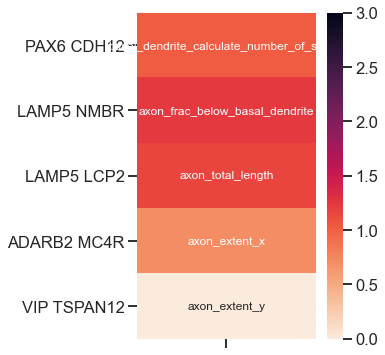

In [84]:
# overall dprime
fig, ax = plt.subplots(figsize=(4,6))
annot=df.loc[df['rank']==0, ['feature']]
sns.heatmap(dist[:,None], yticklabels=clusters, xticklabels=[''], annot=annot, fmt='s', cmap='rocket_r',
            annot_kws=dict(size=12), vmin=0, vmax=3,
           cbar=True, ax=ax)

<AxesSubplot:xlabel='rank'>

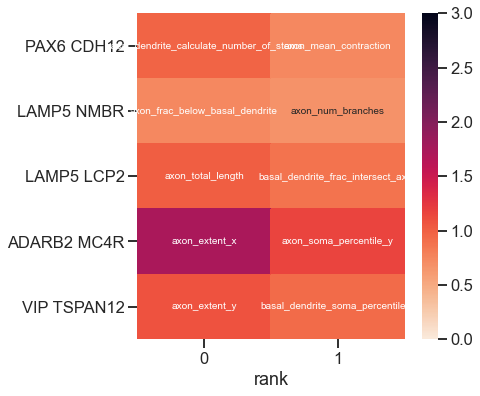

In [85]:
# Not cross-validated!
df2 = df.reset_index().pivot(index='cluster', columns='rank', values=['dprime','feature']).loc[clusters]

fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(df2['dprime'].astype('float'), cmap='rocket_r',  annot=df2['feature'], fmt='s', 
            annot_kws=dict(size=10),  cbar=True, ax=ax, vmin=0, vmax=3,)

### combined m/e

/local1/storage/envs/ipfx38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/local1/storage/envs/ipfx38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/local1/storage/envs/ipfx38/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:112: RuntimeWarning: invalid value encountered in less
  constant_mask = scale < 10 * np.finfo(scale.dtype).eps


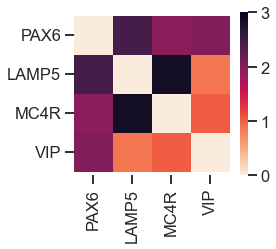

In [275]:
# need to exclude collab cells, etc?
plt.figure(figsize=(3.5,3))
cp.plot_dprime(clf, data, list(morph_features)+list(ephys_features), cluster='homology_type');

## Mouse

In [44]:
subclasses = ['PAX6', 'LAMP5', 'MC4R', 'VIP']

### Ephys

In [57]:
reload(cp)

<module 'patchseq_utils.cluster_pairs' from '/home/tom.chartrand/work/patchseq_human_L1/patchseq_utils/cluster_pairs.py'>

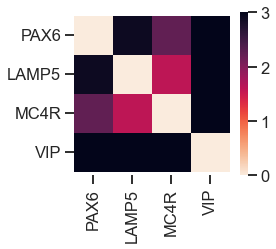

In [59]:
clf = GaussianNB()
clf = RandomForestClassifier(class_weight='balanced')
data = mouse_df
data = mouse_df.loc[lambda df: df.structure.str.contains('VIS')]
data, clusters = subset_data(data, ephys_features, ephys_frac_min=0, cluster_min=5, cluster='homology_type')
plt.figure(figsize=(3.5,3))
cp.plot_dprime(clf, data, complete_features, cluster='homology_type', cluster_list=subclasses);

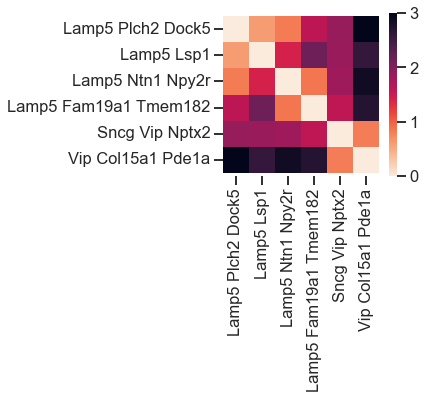

In [72]:
data, clusters = subset_data(data, ephys_features, ephys_frac_min=0, cluster_min=5)
plt.figure(figsize=(3.5,3))
cp.plot_dprime(clf, data, complete_features, cluster=cluster);

### Morph

In [43]:
reload(cp)

<module 'patchseq_utils.cluster_pairs' from '/home/tom.chartrand/work/patchseq_human_L1/patchseq_utils/cluster_pairs.py'>

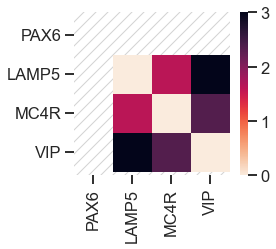

In [47]:
data = mouse_df
data, clusters = subset_data(data, morph_features, ephys_frac_min=0, cluster_min=5, cluster='homology_type')
plt.figure(figsize=(3.5,3))
cp.plot_dprime(clf, data, morph_features, cluster='homology_type', cluster_list=subclasses);

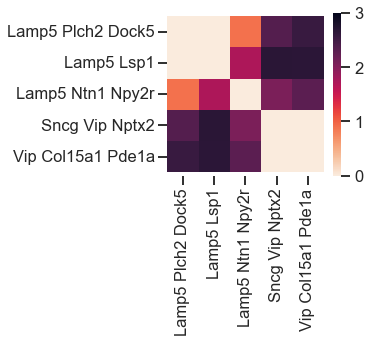

In [75]:
data = mouse_df
data, clusters = subset_data(data, morph_features, ephys_frac_min=0, cluster_min=5, cluster=cluster)
plt.figure(figsize=(3.5,3))
cp.plot_dprime(clf, data, morph_features, cluster=cluster);

## Transcriptomics

### dispersion

In [152]:
def plot_dispersion(stats, name):
    sns.scatterplot(data=stats.T, x='mean', y='std', alpha=0.5, s=10)
    xmax = 5*np.quantile(stats.T.mean(), 0.99)
    plt.xlim(0,xmax)
    plt.ylim(0,xmax)
    
    xx = np.linspace(0,xmax, 500)
    plt.plot(xx, (xx + (xx**2)/1.)**(1/2), 'r')
    plt.plot(xx, (xx + (xx**2)/2.)**(1/2), 'g')
    plt.title(name)
    plt.show()
    
def plot_dispersion_all(shiny_df, gene_list, type_col, type_list, mask_zeros=False):
    shiny_df = shiny_df[shiny_df[type_col].isin(type_list)]
    if mask_zeros:
        get_stats = lambda df: df.replace(0, np.nan).agg(['mean', 'std'])
    else:
        get_stats = lambda df: df.agg(['mean', 'std'])
        

    stats = shiny_df[gene_list].pipe(get_stats)
    plot_dispersion(stats, 'All')
    for name in type_list:
        stats = shiny_df.loc[lambda df: df[type_col]==name, gene_list].pipe(get_stats)
        plot_dispersion(stats, name)

In [164]:
names_df = pd.read_csv("../human_l1/human_MTG_cluster_conversion.csv")
full_names_update = (names_df.set_index(names_df['patchseq_cluster'])
                ['current_FACS_cluster'].to_dict())
import ateam.data.shiny as shiny

l1_types_human_ps = [
        "Inh L1-2 PAX6 CDH12",
        "Inh L1-2 PAX6 TNFAIP8L3",
        "Inh L1 SST NMBR (ADARB2+)",
        "Inh L1-2 LAMP5 DBP",
        "Inh L1-4 LAMP5 LCP2 (rosehip)",
        "Inh L1 SST CHRNA4 (ADARB2+)",
        "Inh L1-2 GAD1 MC4R (ADARB2+)",
        # "Inh L1-3 PAX6 SYT6 (Sncg)",
        "Inh L1-2 VIP TSPAN12",
        "Inh L1-2 SST BAGE2 (ADARB2+)",
        "Inh L1-2 VIP PCDH20",
]
l1_types_human_facs = [full_names_update[x] for x in l1_types_human_ps]


gene_list = pd.read_csv('/home/tom.chartrand/work/mouse-met-figures/data/human_MTG_markers.csv', 
                      index_col=0)['Gene'].tolist()
len(gene_list)

747

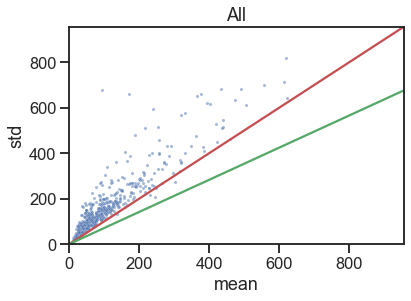

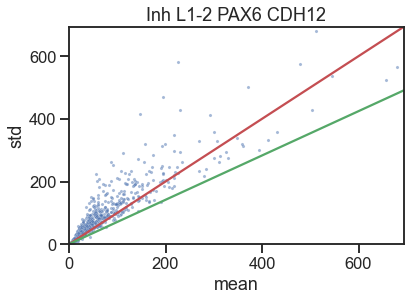

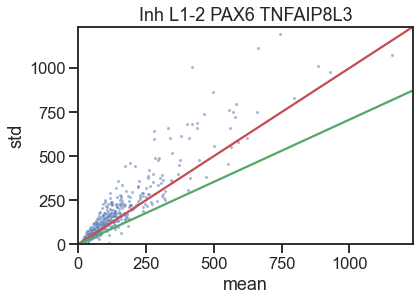

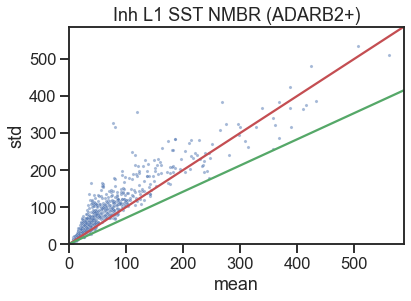

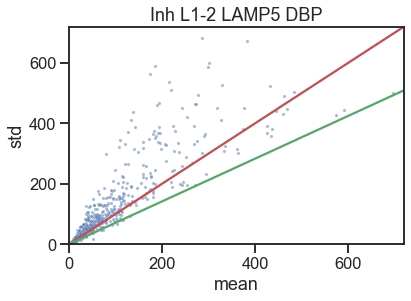

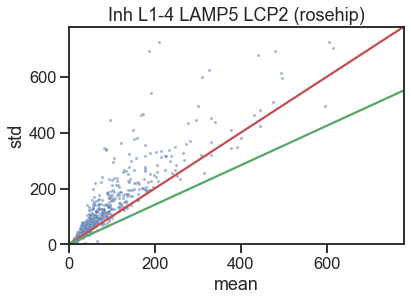

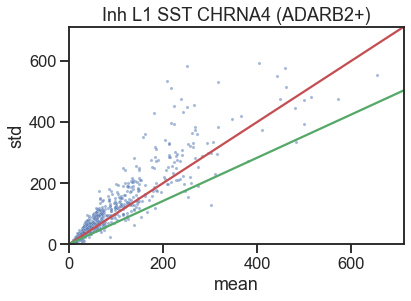

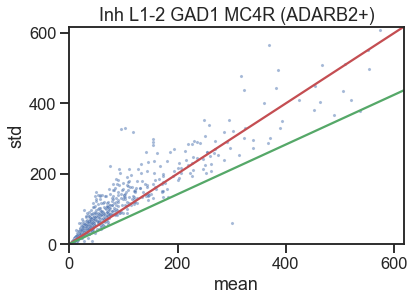

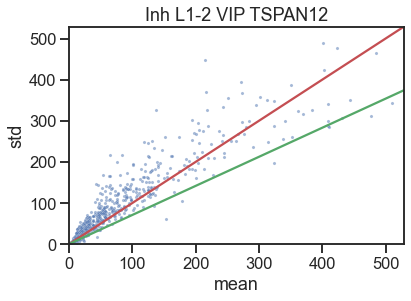

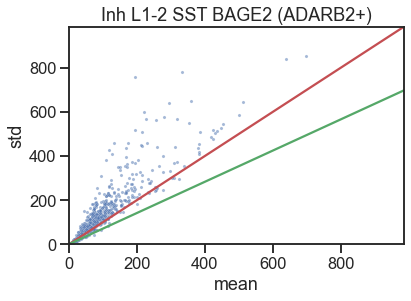

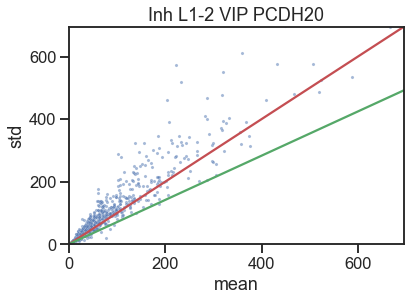

In [159]:
shiny_dir = shiny.shiny_directory('human')
shiny_df = shiny.load_genes_shiny(gene_list, directory=shiny_dir, nms_pass=True)

type_col='topLeaf'
type_list = l1_types_human_ps
plot_dispersion_all(shiny_df, gene_list, type_col, type_list, mask_zeros=True)

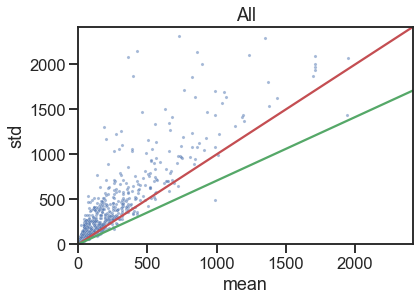

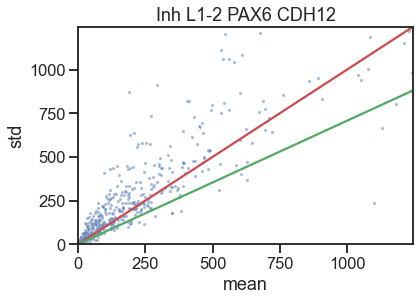

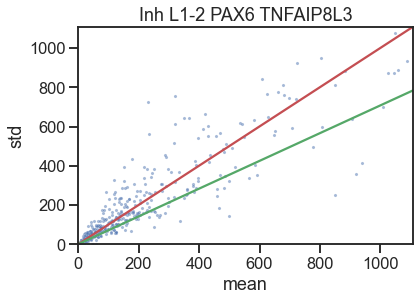

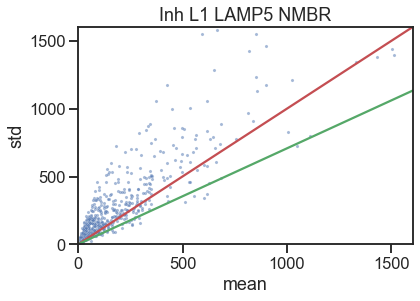

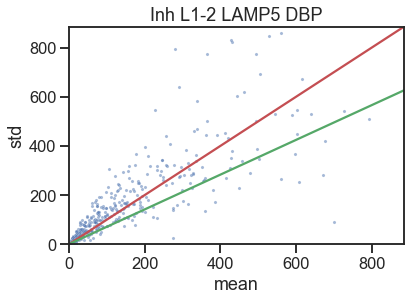

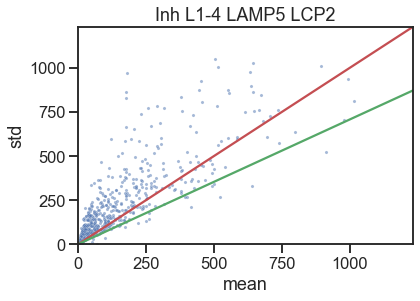

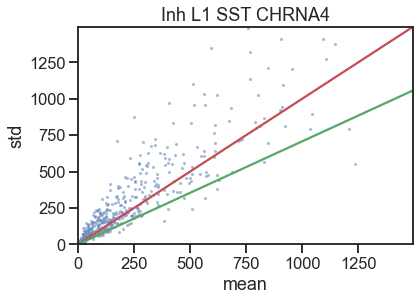

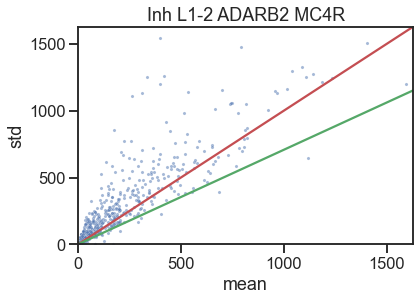

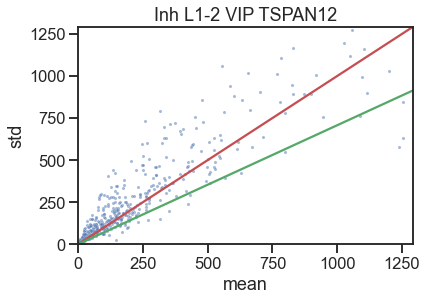

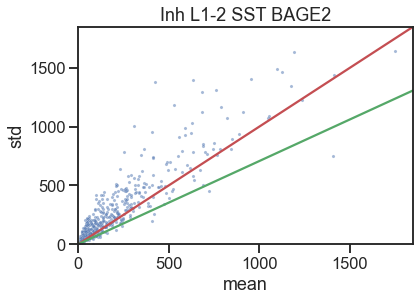

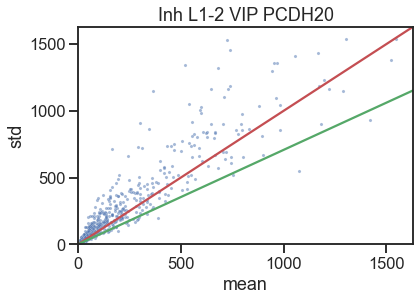

In [160]:
shiny_dir = '/allen/programs/celltypes/workgroups/rnaseqanalysis/shiny/facs_seq/MTG_paper_rev'
shiny_df = shiny.load_genes_shiny(gene_list, directory=shiny_dir, nms_pass=False)

type_col='cluster'
type_list = l1_types_human_facs
plot_dispersion_all(shiny_df, gene_list, type_col, type_list, mask_zeros=True)

In [193]:
def get_group_means(shiny_dir, type_col, type_list, gene_list, ps=True):
    shiny_df = shiny.load_genes_shiny(gene_list, directory=shiny_dir, nms_pass=ps)
    if ps:
        shiny_df[type_col] = shiny_df[type_col].map(full_names_update)
    shiny_df = shiny_df[shiny_df[type_col].isin(type_list)]
    shiny_df[gene_list] = shiny_df[gene_list].transform(lambda x: np.log(1+x))
    res = shiny_df.groupby(type_col)[gene_list].agg('mean')
    return res

In [194]:
shiny_dir = shiny.shiny_directory('human')
type_col='topLeaf'
type_list = l1_types_human_facs
ps_means = get_group_means(shiny_dir, type_col, type_list, gene_list)

shiny_dir = '/allen/programs/celltypes/workgroups/rnaseqanalysis/shiny/facs_seq/MTG_paper_rev'
type_col='cluster'
facs_means = get_group_means(shiny_dir, type_col, type_list, gene_list, ps=False)

Text(0.5, 0, 'snRNA-seq')

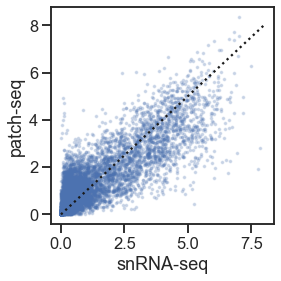

In [288]:
plt.figure(figsize=(4,4))
plt.scatter(x=facs_means.values[:], y=ps_means.values[:], alpha=0.2, s=5)
# data = pd.DataFrame(dict(x=facs_means.values[:], y=ps_means.values[:]))
# plot_corr(data=data, x=x, y=y, spearman=False)
xmax = 8
plt.plot([0, xmax], [0, xmax], ':k')
plt.ylabel('patch-seq')
plt.xlabel('snRNA-seq')

In [161]:
gene_list = pd.read_csv('/home/tom.chartrand/work/mouse-met-figures/data/select_markers.csv', 
                      index_col=0)['Gene'].tolist()
len(gene_list)

4020

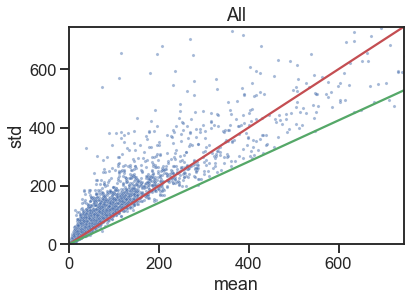

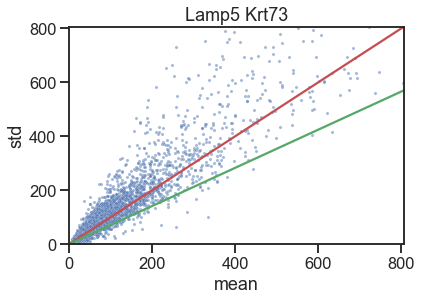

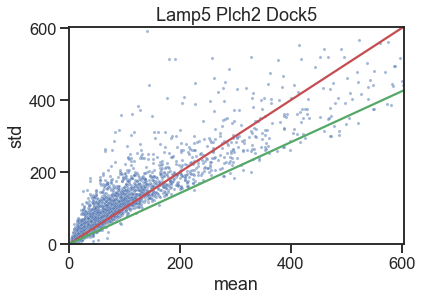

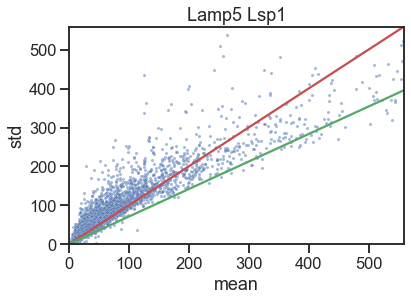

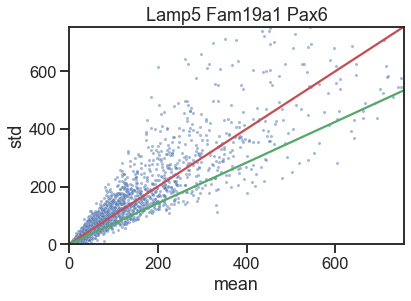

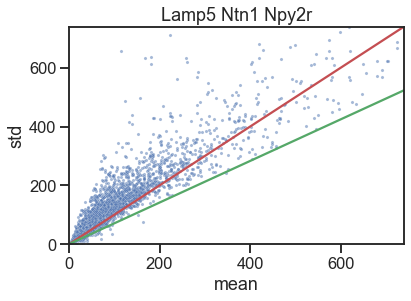

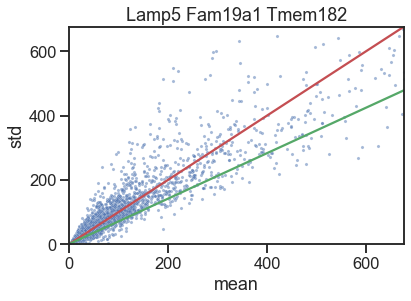

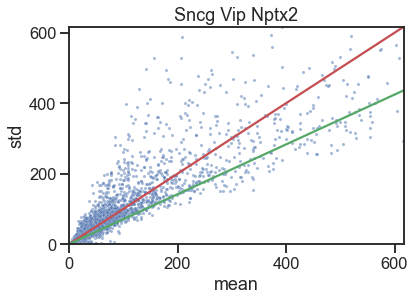

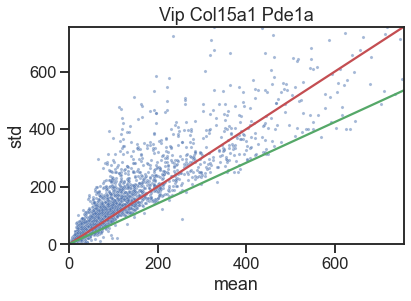

In [162]:
shiny_dir = shiny.shiny_directory('mouse')
shiny_df = shiny.load_genes_shiny(gene_list, directory=shiny_dir, nms_pass=True)

type_col='topLeaf'
type_list = ttypes_mouse.categories
plot_dispersion_all(shiny_df, gene_list, type_col, type_list, mask_zeros=True)

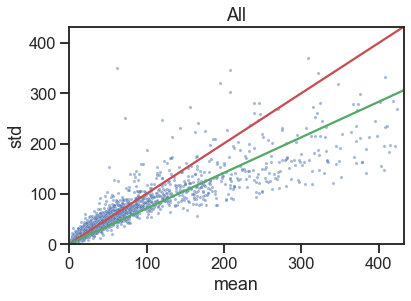

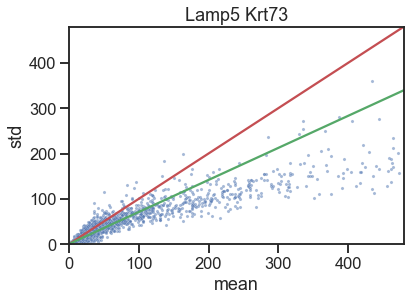

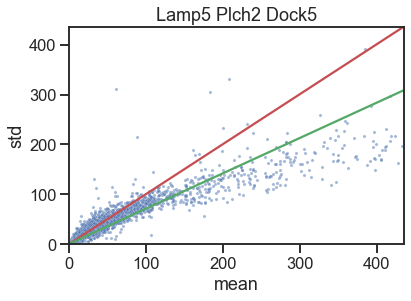

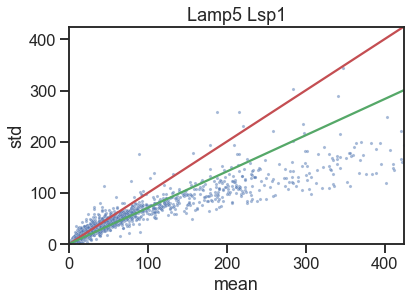

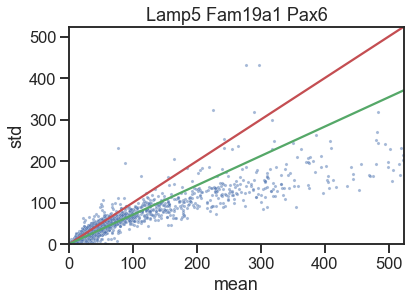

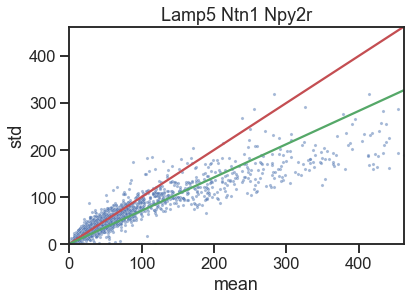

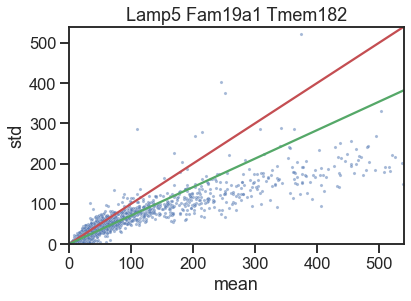

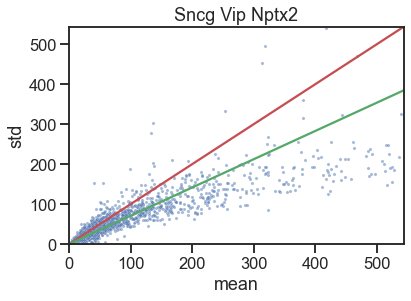

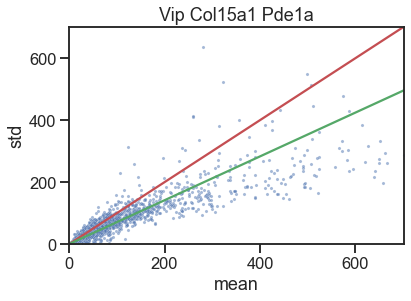

In [163]:
shiny_dir = "/allen/programs/celltypes/workgroups/rnaseqanalysis/shiny/facs_seq/Mm_VISp_AIT2.3.0_20047_202005"
shiny_df = shiny.load_genes_shiny(gene_list, directory=shiny_dir, nms_pass=False)

type_col='cluster'
type_list = ttypes_mouse.categories
plot_dispersion_all(shiny_df, gene_list, type_col, type_list, mask_zeros=True)

### dprime

In [14]:
sct = pd.read_feather(projectdir/"seurat_sct_human_ps.feather").T
sct = human_df.join(sct, on='sample_id', how='inner')

In [39]:
import scipy.spatial.distance as distance
def get_shiny(shiny_dir, gene_list, type_col='topLeaf', nms_pass=True, transforms=[], species='human'):
    shiny_df = shiny.load_genes_shiny(gene_list, directory=shiny_dir, nms_pass=nms_pass)
    shiny_df['t-type'] = shiny_df[type_col]
    for fcn in transforms:
        shiny_df['t-type'] = shiny_df['t-type'].map(fcn)
    if species=='human':
        shiny_df['subclass'] = shiny_df['t-type'].map(homology_mapping_human)
    if species=='mouse':
        shiny_df['subclass'] = shiny_df['t-type'].map(homology_mapping_mouse)
    # in case some requested genes are missing
    gene_list = shiny_df.columns.intersection(gene_list)
    return shiny_df, gene_list

def get_gene_data(shiny_df, gene_list, type_col='t-type', 
                  query=None, type_list=None, normalize=True, log=False):
    if type_list is not None:
        shiny_df = shiny_df[shiny_df[type_col].isin(type_list)].copy()
    if query is not None:
        shiny_df = shiny_df.query(query)
    gene_list = shiny_df.columns.intersection(gene_list)
    data = shiny_df[gene_list].values
    # Normalization
    if normalize:
        cell_totals = data.sum(axis=1)
        avg_total = cell_totals.mean()
        data = avg_total * data / cell_totals[:, np.newaxis]
    if log:
        data = np.log(data+1)
    shiny_df[gene_list] = data
    print("using data with shape {}".format(data.shape))
    return shiny_df

def tx_dprime(df, features, cluster_label, type_list=None, n_folds=5, r=3, zero_inflated=True, ):
    type_labels = df[cluster_label]
    data = df[features].values
    if type_list is None:
        type_list = type_labels.unique()
    # d-prime calculation
    if zero_inflated:
        dprime_results = dprime.zinb_dprime(
            data, type_list, type_labels, n_folds=n_folds,
            r=r, a=8, mu0=50)
    else:
        dprime_results = dprime.negative_binomial_dprime(
            data, type_list, type_labels, n_folds=n_folds,
            r=r)

    dprime_mat = distance.squareform(
        [np.abs(dprime_results[k]["dprime"]) for k in dprime_results])
    output_dprime_df = pd.DataFrame(dprime_mat, index=type_list, columns=type_list)
#     return output_dprime_df, dprime_results
    return output_dprime_df

In [30]:
gene_list = pd.read_csv('/home/tom.chartrand/work/mouse-met-figures/data/human_MTG_markers.csv', 
                      index_col=0)['Gene'].tolist()
shiny_dir = shiny.shiny_directory('human')
shiny_df, gene_list = get_shiny(shiny_dir, gene_list, type_col='topLeaf', nms_pass=True, 
                     transforms=[shorten_name, names_update], species='human')
data = get_gene_data(shiny_df, gene_list, type_col='t-type', 
                  query=None, type_list=ttypes_human.categories, log=True, normalize=False)

using data with shape (658, 747)


In [31]:
# clf = LogisticRegression(class_weight='balanced', C=0.1)
clf = LinearDiscriminantAnalysis()
ps_dprime_lda, _ = cp.pairwise_cluster_distances(clf, data, gene_list, 't-type')

(0.0, 8.0, 8.0, 0.0)

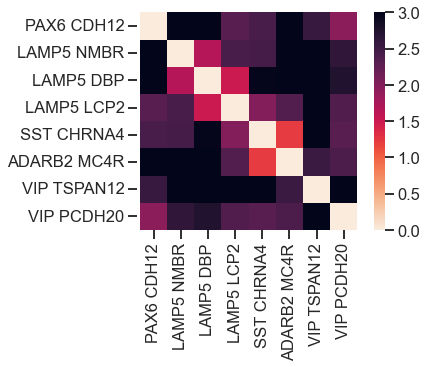

In [33]:
plt.figure(figsize=(5,4))
sns.heatmap(ps_dprime_lda.loc[clusters,clusters], cmap='rocket_r', vmin=0, vmax=3, cbar=True)
plt.axis('equal')

(0.0, 10.0, 10.0, 0.0)

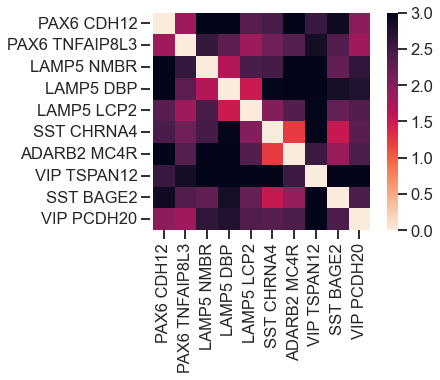

In [44]:
plt.figure(figsize=(5,4))
sns.heatmap(ps_dprime_lda.loc[ttypes_human.categories,ttypes_human.categories],
            cmap='rocket_r', vmin=0, vmax=3, cbar=True)
plt.axis('equal')

In [40]:
ps_dprime = tx_dprime(data, gene_list, 't-type', zero_inflated=False, r=1)

plt.figure(figsize=(5,4))
sns.heatmap(ps_dprime.loc[clusters, clusters], cmap='rocket_r', vmin=0, vmax=3, cbar=True)
plt.axis('equal')
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'unique'

using data with shape (567, 747)
0


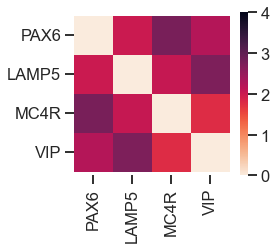

In [326]:
type_col='topLeaf'
type_list = l1_types_human_ps
data = get_gene_data(shiny_df, gene_list, query='core_l1_type', normalize=True)
human_subclass_dprime = tx_dprime(data, gene_list, 'subclass', zero_inflated=False, r=1)

plt.figure(figsize=(3.5, 3))
sns.heatmap(human_subclass_dprime, cmap='rocket_r', vmin=0, vmax=4, cbar=True)
plt.axis('equal')
plt.show()

using data with shape (658, 747)
0


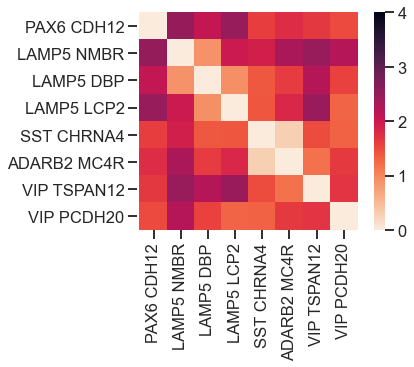

In [78]:
ps_dprime = tx_dprime(shiny_dir, gene_list, l1_types_human_ps, r=1, zero_inflated=True, translate_ps_names=True)
plt.figure(figsize=(5,4))
sns.heatmap(ps_dprime.loc[clusters, clusters], cmap='rocket_r', vmin=0, vmax=4, cbar=True)
plt.axis('equal')
plt.show()

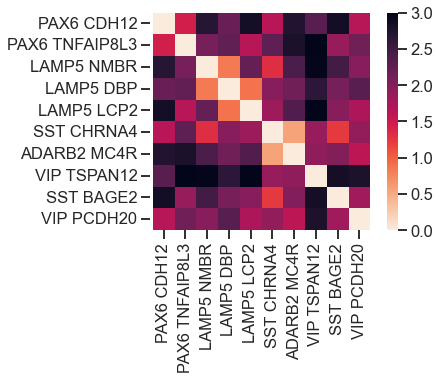

In [296]:
plt.figure(figsize=(5,4))
sns.heatmap(ps_dprime, cmap='rocket_r', vmin=0, vmax=3, cbar=True)
plt.axis('equal')
plt.show()

In [208]:
shiny_dir = '/allen/programs/celltypes/workgroups/rnaseqanalysis/shiny/facs_seq/MTG_paper_rev'
types = l1_types_human+["Inh L1-2 VIP LBH"]
types = l1_types_human_facs
facs_dprime = tx_dprime(shiny_dir, gene_list, types, zero_inflated=False, r=1,
                        nms_pass=False, type_col='cluster')

using data with shape (1136, 747)
0


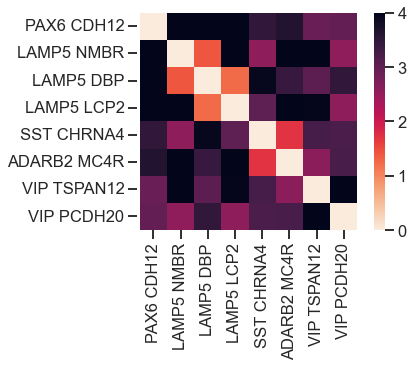

In [209]:
plt.figure(figsize=(5,4))
sns.heatmap(facs_dprime.loc[clusters, clusters], cmap='rocket_r', vmin=0, vmax=4, cbar=True)
plt.axis('equal')
plt.show()

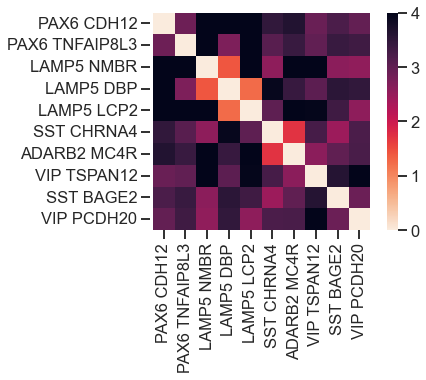

In [281]:
plt.figure(figsize=(5,4))
sns.heatmap(facs_dprime, cmap='rocket_r', vmin=0, vmax=4, cbar=True)
plt.axis('equal')
plt.show()

### mouse TX

In [298]:
gene_list = pd.read_csv('/home/tom.chartrand/work/mouse-met-figures/data/select_markers.csv', 
                      index_col=0)['Gene'].tolist()
len(gene_list)

4020

In [303]:
shiny_dir = shiny.shiny_directory('mouse')
type_col='topLeaf'
type_list = ttypes_mouse.categories
mouse_ps_dprime = tx_dprime(shiny_dir, gene_list, type_list, zero_inflated=False, r=1,
                        nms_pass=True, type_col=type_col)


using data with shape (1124, 4020)
0


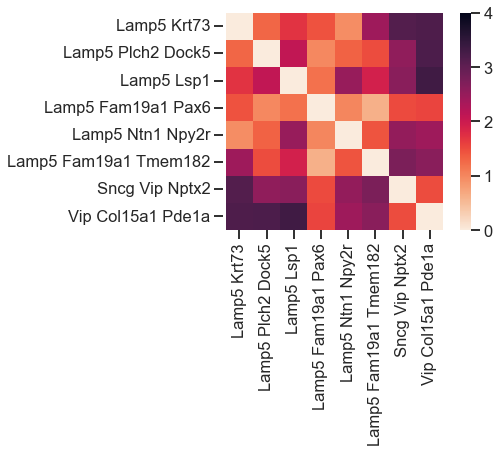

In [304]:
plt.figure(figsize=(5,4))
sns.heatmap(mouse_ps_dprime, cmap='rocket_r', vmin=0, vmax=4, cbar=True)
plt.axis('equal')
plt.show()

using data with shape (1124, 4020)
0


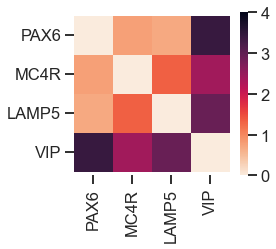

In [308]:

mouse_subclass_dprime = tx_dprime(shiny_dir, gene_list, type_list, zero_inflated=False, r=1,
                        nms_pass=True, type_col=type_col, subclass_dict=homology_mapping_mouse)
plt.figure(figsize=(3.5, 3))
sns.heatmap(mouse_subclass_dprime, cmap='rocket_r', vmin=0, vmax=4, cbar=True)
plt.axis('equal')
plt.show()

### cross-modality correlation

In [242]:
def get_distances(df1, df2=None, name1='1', name2='2'):
    cols = df1.columns if df2 is None else df1.columns.intersection(df2.columns)
    dflat = df1.loc[cols, cols].unstack().rename(name1).to_frame()
    if df2 is not None:
        dflat = dflat.join(df2.loc[cols, cols].unstack().rename(name2))
    dflat = dflat.reset_index().loc[lambda df: df['level_0']>df['level_1']]
    dflat['pair_type'] = dflat.apply(lambda x: 'within' 
                                     if homology_mapping_human[x['level_0']] == homology_mapping_human[x['level_1']] 
                                 else 'between', axis=1)
    return dflat.set_index(['level_0', 'level_1'])

In [213]:
from scipy.stats import spearmanr, pearsonr
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.isotonic import IsotonicRegression
def plot_corr(data, x, y, spearman=True, smooth=True, ax=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    if spearman:
        corr, p = spearmanr(data[x], data[y], nan_policy='omit')
    else:
        corr, p = pearsonr(data[x], data[y])
    if not spearman:
        sns.regplot(data=data, x=x, y=y, ax=ax)
    sns.scatterplot(data=data, x=x, y=y, ax=ax, **kwargs)

    if spearman:
        if smooth:
            smoothed = lowess(data[y], data[x])
            ax.plot(*smoothed.T, 'grey')
        else:        
            xsmooth = np.linspace(min(data[x]), max(data[x]), 200)
            ysmooth = IsotonicRegression(increasing='auto').fit(data[x], data[y]).predict(xsmooth)
            ax.plot(xsmooth, ysmooth, 'grey')

    summary = f"r={corr:.2g}, p={p:.2g}"
    ax.text(0.5, 0.99, summary, transform=ax.transAxes,
        verticalalignment='top', horizontalalignment='center')
    sns.despine()

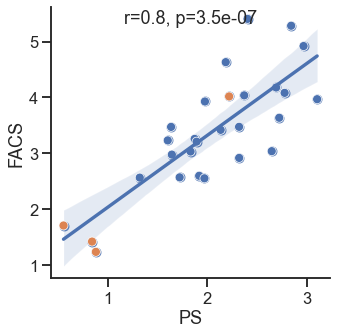

In [216]:
x = 'PS'
y = 'FACS'
dflat = get_distances(ps_dprime.loc[clusters, clusters], facs_dprime.loc[clusters, clusters], x, y)
fig, ax = plt.subplots(figsize=(5,5))
plot_corr(data=dflat, x=x, y=y, spearman=False, hue='pair_type', legend=False, ax=ax, smooth=True)

(0.42876827643906146,
 3.2295941757862803,
 0.31884717760414205,
 4.041995831501835)

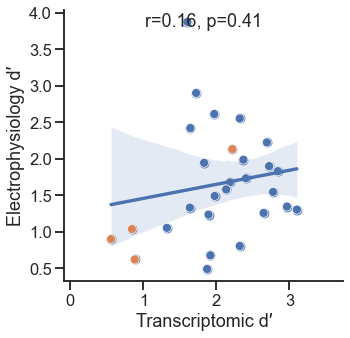

In [219]:
x = 'Transcriptomic d′'
y = 'Electrophysiology d′'
dflat = get_distances(ps_dprime, ephys_dprime, x, y)

fig, ax = plt.subplots(figsize=(5,5))
plot_corr(data=dflat, x=x, y=y, spearman=False, hue='pair_type', legend=False, ax=ax, smooth=True)
plt.axis('equal')

In [ ]:
# dflat = dflat.join(get_distances(morph_dprime, name1='morph'), rsuffix='_r')
# sns.scatterplot(data=dflat.query("pair_type=='between'"), x=x, y=y,  hue='morph', legend=True, ax=ax)

# pcdh = (dflat.level_0=='VIP PCDH20') | (dflat.level_1=='VIP PCDH20') 

(0.0, 4.0)

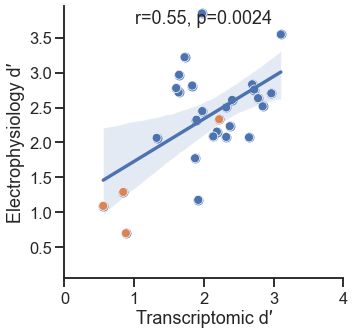

In [292]:
x = 'Transcriptomic d′'
y = 'Electrophysiology d′'
dflat = get_distances(ps_dprime, ephys_dprime_rf, x, y)

fig, ax = plt.subplots(figsize=(5,5))
plot_corr(data=dflat, x=x, y=y, spearman=False, hue='pair_type', legend=False, ax=ax, smooth=True)

plt.axis('equal')
plt.xlim(0,4)
plt.ylim(0,4)

(0.0, 4.0)

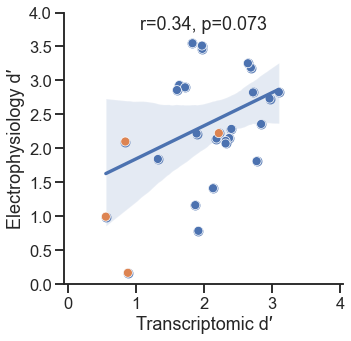

In [291]:
x = 'Transcriptomic d′'
y = 'Electrophysiology d′'
dflat = get_distances(ps_dprime, ephys_dprime_log, x, y)

fig, ax = plt.subplots(figsize=(5,5))
plot_corr(data=dflat, x=x, y=y, spearman=False, hue='pair_type', legend=False, ax=ax, smooth=True)

plt.axis('equal')
plt.xlim(0,4)
plt.ylim(0,4)

(0.5630139933038594, 3.457137209086984, 0.31884717760414205, 4.041995831501835)

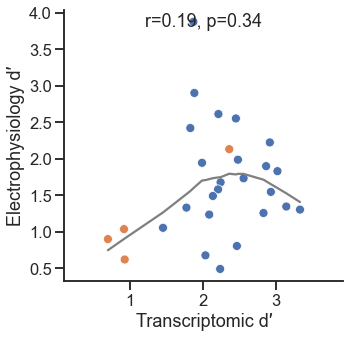

In [29]:
fig, ax = plt.subplots(figsize=(5,5))
plot_corr(data=dflat, x=x, y=y, hue='pair_type', legend=False, ax=ax, smooth=True)
plt.axis('equal')

(0.0, 6.287403803903544)

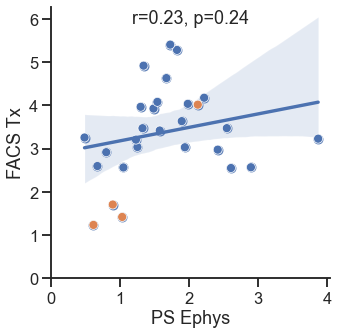

In [217]:
x = 'PS Ephys'
y = 'FACS Tx'
dflat = get_distances(ephys_dprime, facs_dprime, x, y)
fig, ax = plt.subplots(figsize=(5,5))
plot_corr(data=dflat, x=x, y=y, hue='pair_type', legend=False, ax=ax, smooth=True, spearman=False)
ax.set_xlim(0,None)
ax.set_ylim(0,None)

In [37]:
dflat.loc[lambda df: df['PS Ephys'] > 2/3*df['FACS Tx']]

,level_0,level_1,PS Ephys,FACS Tx,pair_type
10,LAMP5 NMBR,LAMP5 DBP,1.033859,1.519298,within
56,VIP PCDH20,PAX6 CDH12,2.418032,3.038083,between
57,VIP PCDH20,LAMP5 NMBR,2.610221,2.622140,between
59,VIP PCDH20,LAMP5 LCP2,2.898564,2.631184,between
61,VIP PCDH20,ADARB2 MC4R,3.872762,3.325701,between


(0.0, 5.6144049628129284)

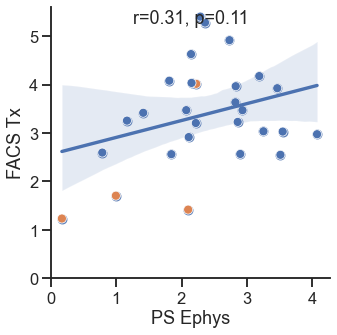

In [294]:
x = 'PS Ephys'
y = 'FACS Tx'
dflat = get_distances(ephys_dprime_log, facs_dprime, x, y)
fig, ax = plt.subplots(figsize=(5,5))
plot_corr(data=dflat, x=x, y=y, hue='pair_type', legend=False, ax=ax, smooth=True, spearman=False)
ax.set_xlim(0,None)
ax.set_ylim(0,None)

(0.0, 5.830343608825847)

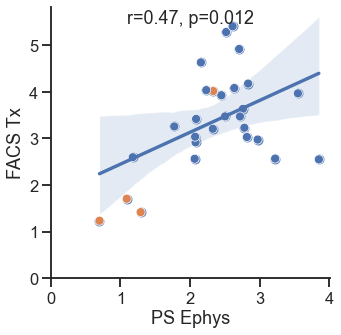

In [293]:
x = 'PS Ephys'
y = 'FACS Tx'
dflat = get_distances(ephys_dprime_rf, facs_dprime, x, y)
fig, ax = plt.subplots(figsize=(5,5))
plot_corr(data=dflat, x=x, y=y, hue='pair_type', legend=False, ax=ax, smooth=True, spearman=False)
ax.set_xlim(0,None)
ax.set_ylim(0,None)

In [86]:
dflat.loc[lambda df: df['PS Ephys'] > 1.1*df['FACS Tx']]

,level_0,level_1,PS Ephys,FACS Tx,pair_type
57,VIP PCDH20,LAMP5 NMBR,3.712694,2.622140,between
59,VIP PCDH20,LAMP5 LCP2,3.434753,2.631184,between


In [250]:
from scipy.stats import spearmanr
import seaborn as sns

def dprime_similarity(df1, df2):
    cols = df1.columns.intersection(df2.columns)
    x1 = distance.squareform(df1.loc[cols, cols].values)
    x2 = distance.squareform(df2.loc[cols, cols].values)
    r, p = pearsonr(x1, x2)
    return r

def dprime_distplot(dprime_list, names, clusters=None):
    clusters = clusters or dprime_list[0].columns
    dist_vals = [distance.squareform(df.loc[clusters, clusters].values) for df in dprime_list]
    df = pd.DataFrame(dist_vals, index=names)
    all_dprimes = df.T.melt(var_name='dataset', value_name='dprime')

    # sns.displot(data=all_dprimes, x='dprime', hue='dataset', kind='kde')
    sns.violinplot(data=all_dprimes, x='dprime', y='dataset', cut=0)

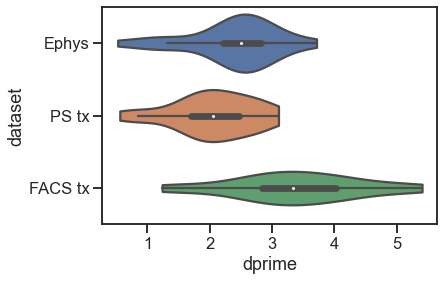

In [252]:
dprime_list = [ephys_dprime_rf, ps_dprime, facs_dprime, ]
names = ['Ephys', 'PS tx', 'FACS tx', ]
dprime_distplot(dprime_list, names)

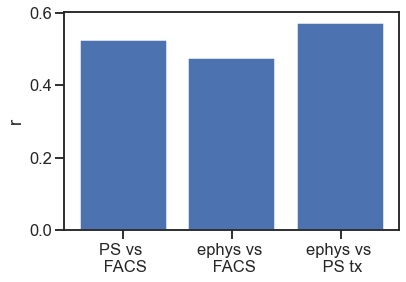

In [254]:
r1 = dprime_similarity(ps_dprime.loc[clusters, clusters], facs_dprime.loc[clusters, clusters])

r2 = dprime_similarity(ephys_dprime_rf, facs_dprime)

r3 = dprime_similarity(ps_dprime, ephys_dprime_rf)

plt.bar(range(3), [x for x in [r1, r2, r3]])
plt.ylabel('r')
plt.xticks(ticks=range(3), labels=['PS vs \n FACS', 'ephys vs \n FACS', 'ephys vs \n PS tx'])
plt.show()

### Ion channel gene set

In [94]:
gene_df = pd.read_csv('../data/ion_channel_gene_group.tsv', sep=None)
ion_genes = gene_df['Approved symbol'].tolist()
exclude = ['CATSPERE', 'CATSPERZ']
ion_genes = [x for x in ion_genes if x not in exclude]

shiny_dir = shiny.shiny_directory('human')
ps_ic_dprime = tx_dprime(shiny_dir, ion_genes, l1_types_human, zero_inflated=False)

shiny_dir = '/allen/programs/celltypes/workgroups/rnaseqanalysis/shiny/facs_seq/MTG_paper_rev'
facs_ic_dprime = tx_dprime(shiny_dir, ion_genes, l1_types_human_ps, zero_inflated=False, 
                        nms_pass=False, type_col='cluster', translate_facs_names=True)

dprime_list = [ps_ic_dprime, facs_ic_dprime, ps_dprime, facs_dprime, ]
names = [ 'PS IC', 'FACS IC', 'PS tx', 'FACS tx', ]
dprime_distplot(dprime_list, names)

/tmp/ipykernel_6769/1901144640.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  gene_df = pd.read_csv('../data/ion_channel_gene_group.tsv', sep=None)


using data with shape (658, 328)
0
using data with shape (1136, 328)
0


/local1/storage/envs/ipfx38/lib/python3.8/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


ValueError: Distance matrix 'X' must be symmetric.

using data with shape (658, 428)
0
using data with shape (1136, 428)
0


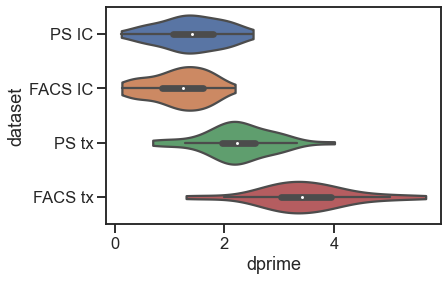

In [127]:
gene_df = pd.read_csv('../genes/ic_genes.txt', header=None)
ion_genes = gene_df[0].tolist()

shiny_dir = shiny.shiny_directory('human')
ps_ic_dprime = tx_dprime(shiny_dir, ion_genes, l1_types_human_ps, zero_inflated=False,
                          translate_ps_names=True)

shiny_dir = '/allen/programs/celltypes/workgroups/rnaseqanalysis/shiny/facs_seq/MTG_paper_rev'
facs_ic_dprime = tx_dprime(shiny_dir, ion_genes, l1_types_human_facs, zero_inflated=False, 
                        nms_pass=False, type_col='cluster')

dprime_list = [ps_ic_dprime, facs_ic_dprime, ps_dprime, facs_dprime, ]
names = [ 'PS IC', 'FACS IC', 'PS tx', 'FACS tx', ]
dprime_distplot(dprime_list, names)

(0.0, 2.402342985155949)

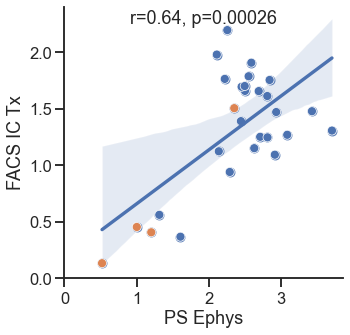

In [128]:
x = 'PS Ephys'
y = 'FACS IC Tx'
dflat = get_distances(ephys_dprime_rf, facs_ic_dprime.loc[clusters, clusters], x, y)
fig, ax = plt.subplots(figsize=(5,5))
plot_corr(data=dflat, x=x, y=y, hue='pair_type', legend=False, ax=ax, smooth=True, spearman=False)
ax.set_xlim(0,None)
ax.set_ylim(0,None)

(0.0, 2.67025894485524)

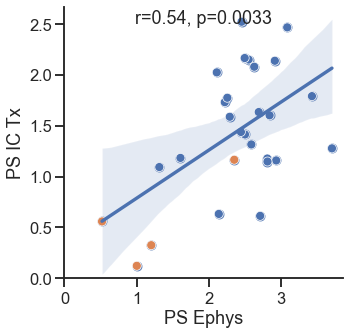

In [130]:
x = 'PS Ephys'
y = 'PS IC Tx'
dflat = get_distances(ephys_dprime_rf, ps_ic_dprime.loc[clusters, clusters], x, y)
fig, ax = plt.subplots(figsize=(5,5))
plot_corr(data=dflat, x=x, y=y, hue='pair_type', legend=False, ax=ax, smooth=True, spearman=False)
ax.set_xlim(0,None)
ax.set_ylim(0,None)

## subclass level species comparison

In [95]:
gene_list = pd.read_csv('/home/tom.chartrand/work/mouse-met-figures/data/human_MTG_markers.csv', index_col=0)['Gene'].tolist()
shiny_dir = shiny.shiny_directory('human')
subclass_dict = {key:val for key, val in homology_mapping_human.items() if not 'other' in val}
ps_subclass_dprime = tx_dprime(shiny_dir, gene_list, l1_types_human, zero_inflated=False, 
                               shorten_names=True,
                               subclass_dict=subclass_dict)

using data with shape (575, 747)
0


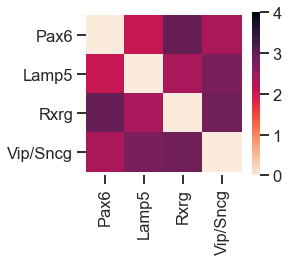

In [96]:
plt.figure(figsize=(3.5,3))
sns.heatmap(ps_subclass_dprime, cmap='rocket_r', vmin=0, vmax=4, cbar=True)
plt.axis('equal')
plt.show()

In [97]:
gene_list = pd.read_csv('/home/tom.chartrand/work/mouse-met-figures/data/human_MTG_markers.csv', index_col=0)['Gene'].tolist()
shiny_dir = '/allen/programs/celltypes/workgroups/rnaseqanalysis/shiny/facs_seq/MTG_paper_rev'
subclass_dict = {key:val for key, val in homology_mapping_human.items() if not 'other' in val}
facs_subclass_dprime = tx_dprime(shiny_dir, gene_list, l1_types_human, zero_inflated=False, 
                            shorten_names=True,
                               subclass_dict=subclass_dict, 
                               nms_pass=False, type_col='cluster', translate_facs_names=True)

using data with shape (996, 747)
0


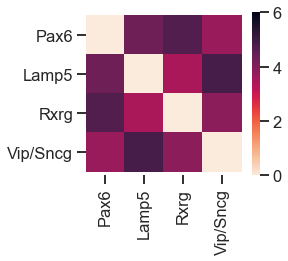

In [98]:
plt.figure(figsize=(3.5,3))
hom_order = ['Pax6','Lamp5','Rxrg','Vip/Sncg']
sns.heatmap(facs_subclass_dprime.loc[hom_order, hom_order], cmap='rocket_r', vmin=0, vmax=6, cbar=True)
plt.axis('equal')
plt.show()

In [99]:
shiny_dir = shiny.shiny_directory('mouse')
# shiny_dir = '/allen/programs/celltypes/workgroups/rnaseqanalysis/shiny/patch_seq/star/mouse_patchseq_VISp_20200318_collapsed40_cpm'
gene_list = pd.read_csv("/home/tom.chartrand/work/mouse-met-figures/data/select_markers.csv", index_col=0)['Gene'].tolist()
                      
l1_types_mouse = homology_mapping_mouse.keys()
ps_subclass_dprime_m = tx_dprime(shiny_dir, gene_list, l1_types_mouse, zero_inflated=False, shorten_names=False,
                               subclass_dict=homology_mapping_mouse)

using data with shape (1418, 4020)
0


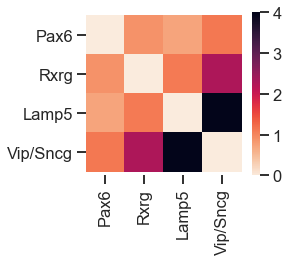

In [100]:
plt.figure(figsize=(3.5,3))
sns.heatmap(ps_subclass_dprime_m, cmap='rocket_r', vmin=0, vmax=4, cbar=True)
plt.axis('equal')
plt.show()

## Constellation diagram overlap

In [615]:

df = pd.read_csv("data/cluster_overlap_matrix.csv", index_col=0)
cl_df = pd.read_csv("/home/tom.chartrand/work/r_patchseq/constellation_trygve/cluster_anno.csv", index_col='name')

for cl in df.columns:
    for cl2 in df.columns:
        df.loc[cl, cl2] /= cl_df.loc[cl, 'size'] + cl_df.loc[cl2, 'size']

df.index = df.index.map(shorten_name)
df.columns = df.columns.map(shorten_name)
l1_types_short = [shorten_name(x) for x in l1_types_human]
df = df.loc[l1_types_short, l1_types_short]

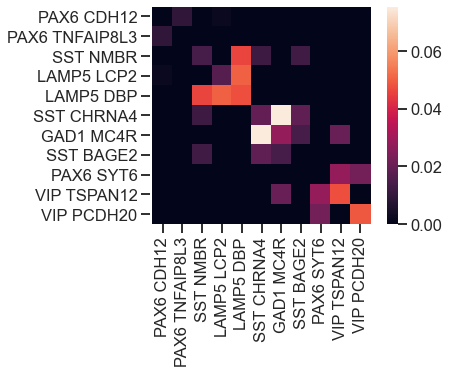

In [624]:
plt.figure(figsize=(5,4))
sns.heatmap(df)
plt.axis('equal')
plt.show()

In [627]:
coclust_d = 1 - df
np.fill_diagonal(coclust_d.values, 0)
dprime_similarity(facs_dprime, coclust_d)

SpearmanrResult(correlation=0.46585829184662103, pvalue=0.0003379547340892743)

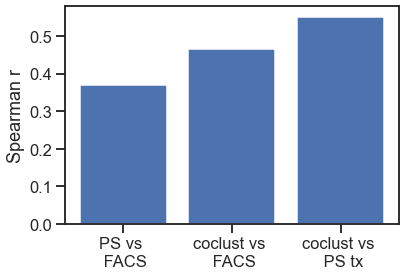

In [630]:
r1 = dprime_similarity(ps_dprime.loc[clusters, clusters], facs_dprime.loc[clusters, clusters])

r2 = dprime_similarity(coclust_d, facs_dprime)

r3 = dprime_similarity(ps_dprime, coclust_d)

plt.bar(range(3), [x.correlation for x in [r1, r2, r3]])
plt.ylabel('Spearman r')
plt.xticks(ticks=range(3), labels=['PS vs \n FACS', 'coclust vs \n FACS', 'coclust vs \n PS tx'])
plt.show()

## FV ephys dprime

[Text(0.5, 4.5, ''), Text(72.90000000000005, 0.5, '')]

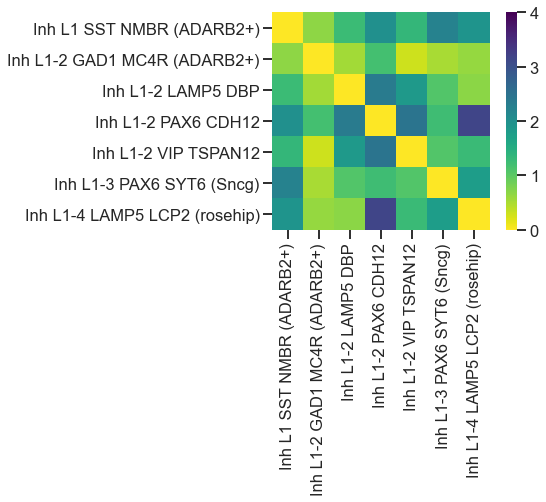

In [191]:
import json
    
ephys_dprime_file = "/home/tom.chartrand/work/mouse-met-figures/derived_data/ephys_all_dprime.json"
with open(ephys_dprime_file, "r") as f:
    data = json.load(f)
    
type_list = data["types"]
fig, ax = plt.subplots()
all_data = data["data"]

df = pd.DataFrame(0*np.eye(len(type_list)), index=type_list, columns=type_list)
for data in all_data.values():
    for d in data:
        val = max(d["dprime"], 0)
        val = val if np.isfinite(val) else 0
        df.loc[d["type1"], d["type2"]] = np.sqrt(val**2 + df.loc[d["type1"], d["type2"]]**2)
df = df + df.T
sns.heatmap(df, square=True,
    cmap="viridis_r",
    xticklabels=type_list,
    yticklabels=type_list,
    vmin=0, vmax=4, ax=ax)
ax.set(xlabel="", ylabel="")

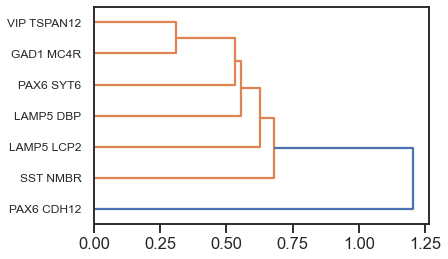

In [196]:
dist = df.values
y = dist.T[np.triu_indices_from(dist, 1)]
y[y>5] = 5
Z = hierarchy.linkage(y)
fig, ax = plt.subplots(figsize=(6,4))
hierarchy.dendrogram(Z, ax=ax, labels=[shorten_name(x) for x in type_list], orientation='right')
plt.show()